<a href="https://colab.research.google.com/github/RachaelJadeMcGrath/Word_embeddings/blob/main/word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
#!pip install gensim
#!pip install plotly
import gensim
import gensim.downloader as api
import pandas as pd
import numpy as np
import nltk


from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))
import string
punkt = list(string.punctuation)

import seaborn as sns
sns.set()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from IPython.display import IFrame
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from scipy.spatial import distance

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Preliminary: matrix multiplication

Matrices are arrays of numbers in of $m \times n$ dimensions, where $m$ and $n$ dimensions ($m$ is the number rows; $n$ the number of columns). These are all examples of matrices:

$$\begin{bmatrix}1& 5 & 7 & 23& 6\end{bmatrix}$$
\
$$\begin{bmatrix}1& 5 \\ 7 & 23 \\ 6 & 9\end{bmatrix}$$
\
$$\begin{bmatrix}5 \\ 7 \\ 9\end{bmatrix}$$
\
$$\begin{bmatrix}1& 5 & i\\ 7 & 3i & e\\ \pi & 6 & 9\end{bmatrix} \ \begin{bmatrix}x^3& x+y & y^2\\ \sqrt{x} & x^2 + y^2 & x^y\end{bmatrix}$$

Linear algebra is the branch of mathematics that deals with matrix operations, and it underwrites much of NLP. For our purposes in learning `word2vec`, we need to know one operation: matrix multiplication.

To multiply two matrices, the number of columns of the first matrix must equal the number of rows of the second matrix. That is, they must have dimensions $m \times n$ and $n \times p$. The multiplication operation consists of  starting with the first row of the first matrix and multiplying each entry in that row with the corresponding entry in the first column of the second matrix and adding the results. This gives the first entry of the new matrix. This is repeated over all the columns of the seond matrix, giving the entire first row of the new matrix. Then, you move on to the second row of the first matrix and repeat the process; this gives the second row of the new matrix. Once the process has completed for all the rows of the first matrix, the operation is compelete. This is easier to follow with an example:

$$\begin{bmatrix}1& 5 \\ 7 & 23 \\ 6 & 9\end{bmatrix} \times \begin{bmatrix}4 & 5 & 10 & 9 \\ 7 & 2 & 5 & 1 \end{bmatrix} = \begin{bmatrix}1\times4+5\times7 & 1\times5+5\times2 & 1\times10+5\times5 & 1\times9 + 5\times1 \\ 7\times4+23\times7 & 7\times5+23\times2 & 7\times10+23\times5 & 7\times9 + 23\times1 \\ 6\times4+9\times7 & 6\times5+9\times2 & 6\times10+9\times5 & 6\times9 + 9\times1\end{bmatrix} = \begin{bmatrix}39 & 15 & 35 & 14 \\ 189 & 81 & 185 & 86 \\ 87 & 48 & 105 & 63\end{bmatrix}$$



# The theory of word embeddings

Most present-day NLP applications are based on word embeddings. These are a way of representing words and larger items of text based on how they behave across a corpus. Typically, these behaviours are learned by neural networks, which can then be used to describe or generate language samples. Large Language Models (LLMs) like ChatGPT, GPT3, and T5 were all made possible be the emergence of word embeddings as a way of describing language.

The linguistic principle behind word embeddings is what's known as the distributional hypothesis. According to [Sahlgren (2006)](https://www.diva-portal.org/smash/get/diva2:1041938/FULLTEXT01.pdf), this can be stated as the claim that:

>there is a correlation between distributional similarity and meaning similarity, which allows us to utilize the former in order to estimate the latter.

That is, words that mean the same thing can generally be found in the same contexts as other words that mean the same thing. For example, the words 'cat' and 'feline' are more likely to share contexts with each other than the words 'dog' or 'canine'. Word embedding models seek to represent this common context mathematically, so we can use them with NLP methods.

The first word embedding model was `word2vec`, which was developed by [Mikolov et al](https://arxiv.org/abs/1301.3781) in 2013. Though `word2vec` has since been superseded by more sophisticated embedding models, the basic principles that underwrite them are the same. So, how does `word2vec` work?

The key insight is that `word2vec` wants to create vector representations of words, such that the vectors for words that share contexts with each other are closer in space. The model starts out by assigning each word a random vector (otherwise called a set of weights). During training on a corpus, the model learns which words are close to each other and adjusts the weights in an iterative process. Usually, the vectors are in 300 dimensions. Why 300? The choice is somewhat abitrary and can be any number, but 300 was found to provide enough paramaters to be empirically useful. In any event 300 parameters gives a lot of degrees of freedom; to quote Jon von Neumann:

> with four parameters I can fit an elephant, and with five I can make him wiggle his trunk.

In more detail, `word2vec` procedes as follows:

1. The corpus is tokenized into words.
2. Each word is represented as a $1 \times V$ matrix using one-hot encoding; this is a vector of size $V$, where $V$ is the vocabulary size.
3. A matrix of $V \times 300$ size is randomly initialised; this is called the hidden layer. Multiplying this vector by the one-hot representation of a word assigns that word one of the 300 place vectors. This vector is its embedding.
4. A second random matrix of $300 \times V$ is created; this is called the output layer. It's the same as the embeddings, but transposed to enable matrix multiplication.
5. For a given word, its behaviour relative to every other word can be captured by getting a similarity measure of its embeddding and the output later weights: this gives a single number that measures vector similarity. Doing this for every word in the vocabulary gives a $1 \times V$ matrix of values.
6. This matrix is converted into a probability distribution using the softmax function. This gives the probability of the word co-occurring with every other word in the vocabulary
7. In the procoess of training, the `word2vec` model learns what words are *actually* associated with each other. It uses this knowledge to adjust the word embeddings and output weights to match the actual probability distributions. It does this iteratively until training ends.

## Toy example

1. Corpus = ['Dogs eat bones', 'Cats eat fish', 'Plants absorb nutrients']

   Vocabulary = ['absorb', 'bones', 'cats', 'dogs', 'eat', 'fish', 'nutrients', 'plants']
   

2. One-hot encoding:

$$absorb = \begin{bmatrix}1& 0 & 0& 0& 0& 0& 0& 0\end{bmatrix}$$
$$bones = \begin{bmatrix}0& 1 & 0& 0& 0& 0& 0& 0\end{bmatrix}$$
$$cats = \begin{bmatrix}0& 0 & 1& 0& 0& 0& 0& 0\end{bmatrix}$$
$$\ldots$$
$$plants = \begin{bmatrix}0& 0 & 0& 0& 0& 0& 0& 1\end{bmatrix}$$


3. Create  random $V \times M$ matrix, where $V$ is vocab size and $M$ is the desired size of the embedding (here, we use 3 for convenience). This is the hidden layer:

$$\begin{bmatrix}2 & 5 & 5 \\7 & 5 & 9 \\2 & 5 & 5 \\1 & 3 & 2 \\0 & 6 & 2 \\3 & 5 & 1 \\5 & 4 & 8 \\3 & 1 & 0\end{bmatrix}$$

  Multiply the one-hot encoding of a word (here, 'plants') by this vector gives a unique word embedding for that word:

$$\begin{bmatrix}0& 0 & 0& 0& 0& 0& 0& 1\end{bmatrix} \times \begin{bmatrix}2 & 5 & 5 \\7 & 5 & 9 \\2 & 5 & 5 \\1 & 3 & 2 \\0 & 6 & 2 \\3 & 5 & 1 \\5 & 4 & 8 \\3 & 1 & 0\end{bmatrix} = \begin{bmatrix}3 & 1& 0\end{bmatrix}$$

4. Next we define a second $M \times V$ matrix using our word embeddings; this is the output layer weights:

$$\begin{bmatrix}2 & 7& 2& 1& 0& 3& 5 & 3 \\5& 5& 5& 3& 6& 5& 4& 1 \\5& 9& 5& 2& 2& 1& 8& 0\end{bmatrix}$$

5. If we take a word––here, 'plants'––and get the cosine similarity of its word embedding with every column in the weights matrix, we get a similarity score between that word and every other word in the vocalbulary:

$$\begin{bmatrix}3 & 1 &0\end{bmatrix} \times \begin{bmatrix}2 & 7& 2& 1& 0& 3& 5 & 3 \\5& 5& 5& 3& 6& 5& 3& 1 \\5& 9& 5& 2& 2& 1& 8& 0\end{bmatrix} = \begin{bmatrix}0.4 & 0.6 & 0.47 & 0.5 & 0.3 & 0.7 & 0.5 & 1\end{bmatrix}$$

   (For example, $cosine \ similarity(\begin{bmatrix}3 & 1 &0\end{bmatrix}, \begin{bmatrix}2 & 5 & 5\end{bmatrix}) = 0.4$)

6. The softmax function $\frac{e^i}{\sum_{j=1}^K e^j}$ converts this matrix of similarity scores into a probability distribution for how likely the word of interest ('plants') will occur with every other word:

$$P(plants|x\in V) = \begin{bmatrix} 0.10 & 0.12 & 0.11 & 0.11 & 0.09 & 0.14 & 0.11 & 0.19 \end{bmatrix}$$

During training, a `word2vec` model learns the actual probability distribution of 'plants' with respect to all the other words and calculates the difference between this true distribution and the randomly initialsed one. This is called the loss function. It then adjusts the word embeddings to minimise the loss function in an iterative process of updating. Training is complete when any further changes cause the loss function to increase. The word embeddings are retained as a representation of how each word behaves in the corpus. Because similar words will generate similar probability distributions due to co-occurrence, their word embeddings will be similar.



# Example: The King James Bible

Let's see what it looks like to train a `word2vec` model with reference to a text––here, the King James version (KJV) of the Bible.


## Step 1: Preprocessing our data.

For `word2vec` to train, it needs a list of sentences that have been tokenized and lemmatized. This means we must:

1. Open our text file
2. Split on sentences
3. Tokenize and lemmatise our sentences and remove stopwords

In [6]:

#Open and read the text file
with open('KJV.txt', 'r') as f:
    bible = f.read()

# Get rid of newline characters and non-ascii gibberish and make everything lowercase
bible = bible.encode('ascii', 'ignore')
bible = bible.decode()
bible = ' '.join(bible.splitlines())
bible = bible.lower()



In [7]:
bible

'the project gutenberg ebook of the king james bible  this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever. you may copy it, give it away or re-use it under the terms of the project gutenberg license included with this ebook or online at www.gutenberg.org. if you are not located in the united states, you will have to check the laws of the country where you are located before using this ebook.  title: the king james bible  release date: august, 1989 [ebook #10] [most recently updated: december 20, 2021]  language: english   *** start of the project gutenberg ebook the king james bible ***     the old testament of the king james version of the bible the first book of moses: called genesis the second book of moses: called exodus the third book of moses: called leviticus the fourth book of moses: called numbers the fifth book of moses: called deuteronomy the book of joshua the book of judge

In [8]:
# Split text into sentences and remove trailing and leading whitespace
bible = bible.split('.')
bible = [i.strip() for i in bible]

In [11]:
from nltk import word_tokenize

In [20]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [21]:
# tokenize into words

bible_tokens = [word_tokenize(i) for i in bible]

In [23]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [24]:
# lemmatize words and remove stopwords and punctuation

bible_lemmas = [[] for i in range(len(bible_tokens))]

for i in range(len(bible_tokens)):
    for j in bible_tokens[i]:
        if j not in stops and j not in punct:
            bible_lemmas[i].append(lemmatizer.lemmatize(j))

## Step 2: Call and train our `word2vec` model

In [25]:
model = gensim.models.Word2Vec(bible_lemmas, min_count= 20, vector_size = 300)

In [26]:
model.wv['jesus']

KeyError: "Key 'jesus' not present"

In [ ]:
model.wv.most_similar(['jesus'])

In [ ]:
model.wv.doesnt_match(['man', 'woman', 'child', 'horse'])

In [ ]:
vocab = model.wv.index_to_key
vectors = [model.wv[i] for i in vocab]

df = pd.DataFrame(vectors)


In [ ]:
df.columns = [str(i) for i in df.columns]

## Step 3: Visualising our data

In [ ]:
# Reduce the dimensionality of the data so we can plot it

pca_1 = PCA(n_components = 3)
comps_1 = pca_1.fit_transform(df)
pc_df_1 = pd.DataFrame(data = comps_1, columns = ['Principal Component '+str(i) for i in range(1, comps_1.shape[1]+1)])
df = pd.concat([df, pc_df_1], axis = 1)
df.index = vocab


In [ ]:
# Cluster our data to see what groups together

kmeans = KMeans(n_clusters=200, random_state=0, n_init="auto").fit(df)
df['clusters_knn'] = [str(i) for i in kmeans.labels_]



In [ ]:
fig = px.scatter_3d(df, x='Principal Component 1', y='Principal Component 2', z='Principal Component 3',
              color='clusters_knn', hover_data = [df.index])

fig.update_traces(marker=dict(size = 5, line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.show('notebook')

# Load a pre-trained model

Word vectors get more accurate the more data they are trained on. Several pre-trained models are available on the `gensim` API. Here, we're going to look at the [Google News dataset](https://huggingface.co/fse/word2vec-google-news-300), which trained on 100 billion words and phrases, giving a vocabulary of three million words of news data.

In [27]:
model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [28]:
model.most_similar(['president'])

[('President', 0.800627589225769),
 ('chairman', 0.6708744764328003),
 ('vice_president', 0.6700226068496704),
 ('chief_executive', 0.6691274642944336),
 ('CEO', 0.6590125560760498),
 ('pesident', 0.6265207529067993),
 ('Vice_President', 0.6216662526130676),
 ('executive', 0.6182477474212646),
 ('prez', 0.5761911273002625),
 ('Presdient', 0.5718376636505127)]

In [31]:
# looking at green policy
model.most_similar(['renewable'])

[('renewable_energy', 0.8236783146858215),
 ('renewables', 0.7485474944114685),
 ('biomass', 0.6651452779769897),
 ('renewable_fuels', 0.6620936393737793),
 ('Renewable', 0.6499089002609253),
 ('biofuels', 0.6431555151939392),
 ('renewable_energies', 0.6319903135299683),
 ('fossil_fuels', 0.626794695854187),
 ('Renewable_energy', 0.6227798461914062),
 ('nonfossil_fuel', 0.6144607067108154)]

In [35]:
model.similarity('renewable_energy', 'coal')

0.51781684

In [32]:
model.similarity('UK', 'France')

0.38679352

In [33]:
model.similarity('UK', 'Mars')

0.11358253

In [36]:
vocab = model.index_to_key


In [42]:
model.doesnt_match(['man', 'CEO', 'president'])

'man'

In [37]:
import random

sample = random.choices(vocab, k = 5)

In [38]:
sample

['performace', 'ADDISON_Texas', 'Yohay_Elam', 'TCVN', 'italicized']

In [40]:
european_countries = [
    "Albania", "Andorra", "Armenia", "Austria", "Azerbaijan", "Belarus", "Belgium",
"Bulgaria", "Croatia", "Cyprus",
    "Denmark", "Estonia", "Finland", "France", "Georgia", "Germany", "Greece",
    "Hungary", "Iceland", "Ireland", "Italy", "Kazakhstan", "Kosovo", "Latvia",
    "Liechtenstein", "Lithuania", "Luxembourg", "Malta", "Moldova", "Monaco",
    "Montenegro", "Netherlands", "Norway", "Poland", "Portugal",
    "Romania", "Russia", "Serbia", "Slovakia", "Slovenia", "Spain",
    "Sweden", "Switzerland", "Turkey", "Ukraine", "UK"]


In [61]:
dist = [[] for i in range(len(european_countries))]

In [48]:
for j in range(len(european_countries)):
    h = european_countries[j]
    for i in european_countries:
            dist[j].append(model.similarity(h,i))

In [56]:
europe = pd.DataFrame(dist)
europe.columns = european_countries
europe.index = european_countries

In [57]:
europe

Albania   Andorra   Armenia   Austria  Azerbaijan   Belarus  \
Albania        1.000000  0.403732  0.558745  0.511910    0.593011  0.543457   
Andorra        0.403732  1.000000  0.412209  0.475845    0.358710  0.419819   
Armenia        0.558745  0.412209  1.000000  0.449461    0.807553  0.656620   
Austria        0.511910  0.475845  0.449461  1.000000    0.426834  0.459470   
Azerbaijan     0.593011  0.358710  0.807553  0.426834    1.000000  0.698007   
Belarus        0.543457  0.419819  0.656620  0.459470    0.698007  1.000000   
Belgium        0.394283  0.335563  0.302933  0.596542    0.278603  0.343340   
Bulgaria       0.708967  0.428588  0.641986  0.578372    0.683861  0.626455   
Croatia        0.668630  0.571555  0.534844  0.646854    0.506253  0.556479   
Cyprus         0.573501  0.371161  0.573232  0.418059    0.533323  0.425337   
Denmark        0.417084  0.415662  0.311602  0.554601    0.330879  0.362893   
Estonia        0.579952  0.534562  0.597702  0.555203    0.613720  0.662501   
Finland        0.446039  0.333922  0.433402  0.586788    0.447343  0.481137   
France         0.311844  0.363053  0.309221  0.517040    0.262552  0.341994   
Georgia        0.300551  0.183954  0.452380  0.186926    0.453066  0.399078   
Germany        0.408748  0.309280  0.317754  0.746106    0.353623  0.387872   
Greece         0.521885  0.318937  0.430219  0.437493    0.407655  0.459643   
Hungary        0.616091  0.410708  0.472569  0.686743    0.502392  0.587849   
Iceland        0.448835  0.360849  0.367758  0.462187    0.386988  0.436392   
Ireland        0.401091  0.343136  0.290075  0.395907    0.262431  0.311823   
Italy          0.526060  0.369152  0.311764  0.562129    0.285207  0.326020   
Kazakhstan     0.577779  0.370483  0.627177  0.454546    0.761845  0.720747   
Kosovo         0.555012  0.241890  0.482647  0.318677    0.452371  0.413175   
Latvia         0.598811  0.471992  0.610460  0.543843    0.604707  0.710845   
Liechtenstein  0.398100  0.589692  0.287916  0.580297    0.303440  0.330129   
Lithuania      0.631076  0.482350  0.608720  0.520236    0.604629  0.682614   
Luxembourg     0.349699  0.392429  0.271383  0.454130    0.249692  0.341667   
Malta          0.501676  0.370426  0.419712  0.374374    0.421832  0.345681   
Moldova        0.649244  0.465476  0.738454  0.476382    0.696681  0.741623   
Monaco         0.234003  0.440951  0.177339  0.352881    0.153737  0.138746   
Montenegro     0.638798  0.509795  0.465846  0.405276    0.462362  0.469798   
Netherlands    0.366242  0.338615  0.218590  0.535181    0.275371  0.309509   
Norway         0.397101  0.377698  0.307404  0.534123    0.365183  0.420264   
Poland         0.574358  0.335721  0.524840  0.602425    0.528703  0.592622   
Portugal       0.450381  0.489899  0.365379  0.476482    0.308018  0.380060   
Romania        0.723589  0.425677  0.566634  0.617194    0.573377  0.613308   
Russia         0.452049  0.285118  0.605756  0.433338    0.672699  0.730356   
Serbia         0.684815  0.353730  0.557243  0.491247    0.530268  0.604462   
Slovakia       0.599556  0.509814  0.509799  0.669346    0.482357  0.658927   
Slovenia       0.652223  0.578810  0.507737  0.609701    0.506771  0.567721   
Spain          0.419465  0.460707  0.345775  0.483828    0.324882  0.303095   
Sweden         0.423314  0.345057  0.331017  0.613756    0.338629  0.454405   
Switzerland    0.390857  0.480635  0.346092  0.730635    0.295052  0.385823   
Turkey         0.559685  0.286041  0.662309  0.442530    0.627469  0.422550   
Ukraine        0.573918  0.341097  0.676651  0.445196    0.723699  0.821953   
UK             0.229675  0.153875  0.146651  0.299047    0.226047  0.188929   

                Belgium  Bulgaria   Croatia    Cyprus  ...    Russia  \
Albania        0.394283  0.708967  0.668630  0.573501  ...  0.452049   
Andorra        0.335563  0.428588  0.571555  0.371161  ...  0.285118   
Armenia        0.302933  0.641986  0.534844  0.573232  ...  0.605756   
Austria       

In [58]:
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt


<Axes: >

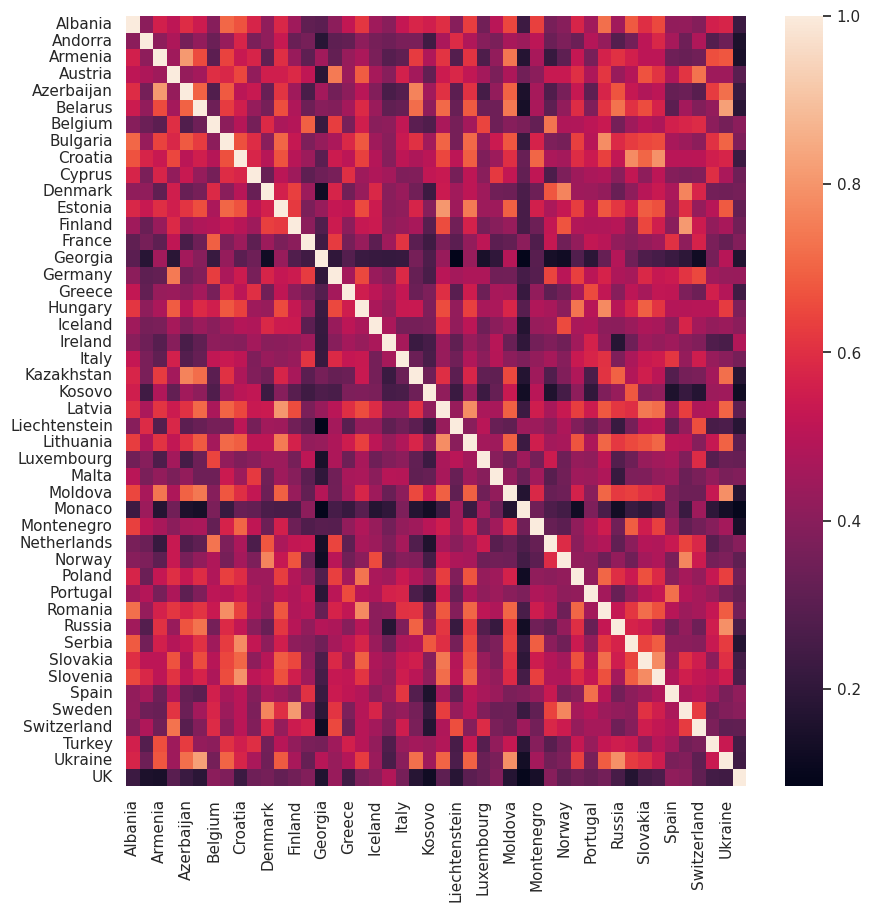

In [59]:
plt.figure(figsize=(10,10))
sns.heatmap(europe)

In [65]:
# having a go with green language
green_policy = [
    "climate_change", "renewable_energy", "carbon_footprint",
    "greenhouse_gas_emissions", "sustainable", "biodiversity_conservation",
    "pollution", "eco_friendly_practices", "clean_energy",
    "environmental_regulations", "wildlife_protection", "water_resource_management",
    "air_quality_standards", "deforestation_prevention", "recycling_programs",
    "green_economy", "sustainable_agriculture", "energy_efficiency",
    "solar_power_incentives", "wind_energy_expansion", "electric_vehicle_adoption",
    "public_transport_enhancement", "waste_reduction_strategies", "plastic_ban_policies",
    "carbon_taxation", "environmental_education", "conservation_areas",
    "habitat_restoration", "marine_protection", "environmental_impact_assessment",
    "clean_water_act", "sustainable_fishing", "urban_green_spaces", "eco_tourism",
    "renewable_fuel_standards", "zero_emission_goals", "climate_resilience",
    "flood_defense_measures", "drought_response_plans", "clean_air_act",
    "environmental_justice", "circular_economy", "green_building_standards",
    "pesticide_regulation", "carbon_sequestration", "ocean_cleanup_initiatives"]



In [68]:
#from gensim.models import KeyedVectors

# Assuming you've already loaded your model
# model = KeyedVectors.load_word2vec_format('path/to/your/model.bin', binary=True)  # or whatever your model format is

# The list of words/phrases you want to check
green_policy = [
    "climate_change", "renewable_energy", "carbon_footprint",
    "greenhouse_gas_emissions", "sustainable_development", "biodiversity_conservation",
    "pollution_control", "eco_friendly_practices", "clean_energy_transition",
    "environmental_regulations", "wildlife_protection", "water_resource_management",
    "air_quality_standards", "deforestation_prevention", "recycling_programs",
    "green_economy", "sustainable_agriculture", "energy_efficiency",
    "solar_power_incentives", "wind_energy_expansion", "electric_vehicle_adoption",
    "public_transport_enhancement", "waste_reduction_strategies", "plastic_ban_policies",
    "carbon_taxation", "environmental_education", "conservation_areas",
    "habitat_restoration", "marine_protection", "environmental_impact_assessment",
    "clean_water_act", "sustainable_fishing", "urban_green_spaces", "eco_tourism",
    "renewable_fuel_standards", "zero_emission_goals", "climate_resilience",
    "flood_defense_measures", "drought_response_plans", "clean_air_act",
    "environmental_justice", "circular_economy", "green_building_standards",
    "pesticide_regulation", "carbon_sequestration", "ocean_cleanup_initiatives"
]

# Check if each word/phrase is in the model's vocabulary
exists_in_model = {term: term in model.key_to_index for term in green_policy}

# Print which words/phrases exist or don't exist in the model
for term, exists in exists_in_model.items():
    print(f"'{term}':", "Exists in model" if exists else "Does not exist in model")


'climate_change': Exists in model
'renewable_energy': Exists in model
'carbon_footprint': Exists in model
'greenhouse_gas_emissions': Exists in model
'sustainable_development': Does not exist in model
'biodiversity_conservation': Exists in model
'pollution_control': Does not exist in model
'eco_friendly_practices': Does not exist in model
'clean_energy_transition': Does not exist in model
'environmental_regulations': Does not exist in model
'wildlife_protection': Does not exist in model
'water_resource_management': Does not exist in model
'air_quality_standards': Does not exist in model
'deforestation_prevention': Does not exist in model
'recycling_programs': Does not exist in model
'green_economy': Does not exist in model
'sustainable_agriculture': Does not exist in model
'energy_efficiency': Does not exist in model
'solar_power_incentives': Does not exist in model
'wind_energy_expansion': Does not exist in model
'electric_vehicle_adoption': Does not exist in model
'public_transport_e

In [71]:
green_terms = pd.DataFrame(green_policy, columns=['Term'])

In [73]:


# Create a dictionary with term existence

exists_in_model = {term: term in model.key_to_index for term in green_policy}

# Convert the dictionary to a pandas DataFrame
green_terms = pd.DataFrame(list(exists_in_model.items()), columns=['Term', 'Exists in Model'])

# Display the DataFrame
green_terms


Term  Exists in Model
0                    climate_change             True
1                  renewable_energy             True
2                  carbon_footprint             True
3          greenhouse_gas_emissions             True
4           sustainable_development            False
5         biodiversity_conservation             True
6                 pollution_control            False
7            eco_friendly_practices            False
8           clean_energy_transition            False
9         environmental_regulations            False
10              wildlife_protection            False
11        water_resource_management            False
12            air_quality_standards            False
13         deforestation_prevention            False
14               recycling_programs            False
15                    green_economy            False
16          sustainable_agriculture            False
17                energy_efficiency            False
18           solar_power_incentives            False
19            wind_energy_expansion            False
20        electric_vehicle_adoption            False
21     public_transport_enhancement            False
22       waste_reduction_strategies            False
23             plastic_ban_policies            False
24                  carbon_taxation            False
25          environmental_education            False
26               conservation_areas            False
27              habitat_restoration             True
28                marine_protection            False
29  environmental_impact_assessment            False
30                  clean_water_act            False
31              sustainable_fishing            False
32               urban_green_spaces            False
33                      eco_tourism             True
34         renewable_fuel_standards            False
35              zero_emission_goals            False
36               climate_resilience            False
37           flood_defense_measures            False
38           drought_response_plans            False
39                    clean_air_act            False
40            environmental_justice            False
41                 circular_economy            False
42         green_building_standards            False
43             pesticide_regulation            False
44             carbon_sequestration             True
45        ocean_cleanup_initiatives            False

In [66]:
dist = [[] for i in range(len(green_policy))]

In [67]:
for j in range(len(green_policy)):
    h = green_policy[j]
    for i in green_policy:
            dist[j].append(model.similarity(h,i))

KeyError: "Key 'pollution_control' not present"